# Analysing mock datasets

In [75]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations

import sys
sys.path.append("../src")

from analysis import *
from inference import *

In [76]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [77]:
path = "../experiment_outputs/test2/"

In [135]:
infer_out_files = natural_sort(os.listdir(f"{path}/inference"))
metadatafiles = [f"metadata{i.split('infer_out_')[1][:-3]}txt" for i in infer_out_files]

In [136]:
metadict_list = []
for file in metadatafiles:
    metatext = open(f"{path}/metadata/"+file, "r").read().split("\n")
    metadict_list.append(get_meta(metatext))

metadict = metadict_list[0]

In [137]:
infer_out_list = [pd.read_csv(f"{path}/inference/{file}", index_col=0) for file in infer_out_files]
infer_out_all = pd.concat(infer_out_list)

In [138]:
infer_out_all.columns

Index(['n_init_cond', 'init_cond_idx', 't_samp_dist_idx', 'measurement_noise',
       'r1', 'r2', 'r3', 'r4', 'r5', 'r6',
       ...
       'A10,4', 'A10,5', 'A10,6', 'A10,7', 'A10,8', 'A10,9', 'A10,10', 'MSPD',
       'CSR', 'ES'],
      dtype='object', length=117)

In [139]:
n_sp = len([i for i in infer_out_all.columns if i[0]=="r"])

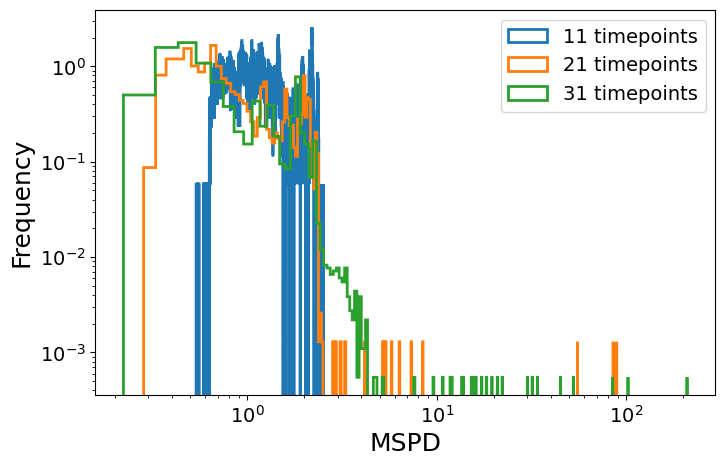

In [103]:
# MSPD frequency
plt.figure(figsize=(8,5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].MSPD.values, 2000,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints", 
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()

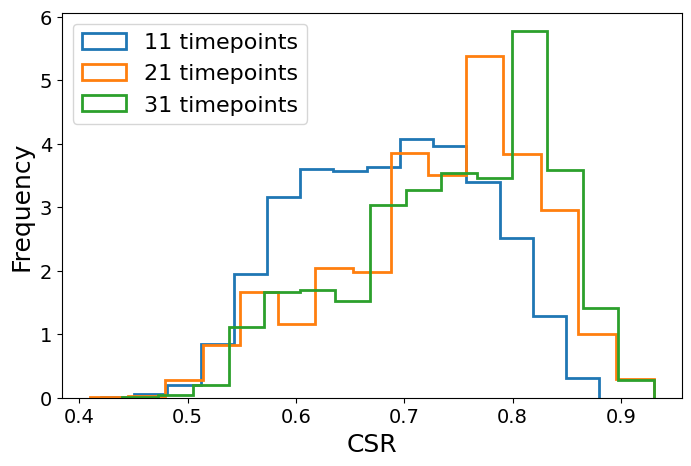

In [104]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].CSR.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

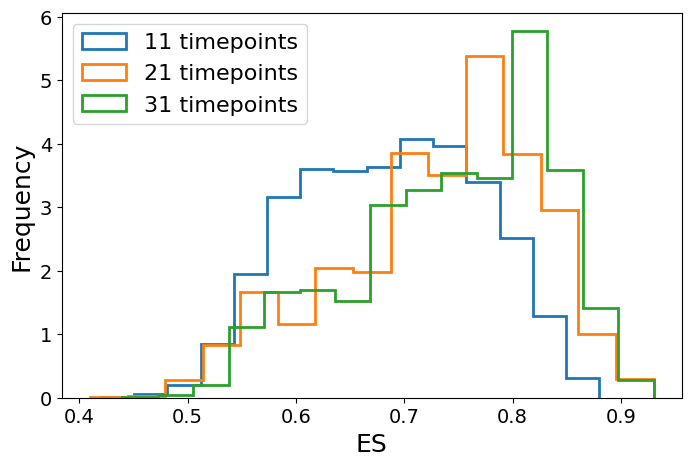

In [105]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].ES.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [106]:
# Difference between CSR and ES scores
(infer_out_all.CSR!=infer_out_all.ES).sum()

0

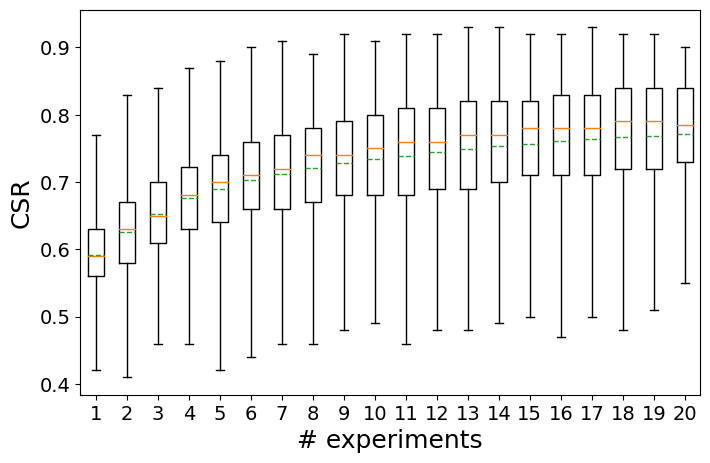

In [107]:
# CSR boxplots over # of experiments
CSR = [infer_out_all[infer_out_all.n_init_cond==i]["CSR"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [140]:
metadict_list[0]["parameters"]

array([ 0.5488135 ,  0.71518937,  0.60276338,  0.54488318,  0.4236548 ,
        0.64589411,  0.43758721,  0.891773  ,  0.96366276,  0.38344152,
       -3.53552807,  0.82024784,  0.46313033,  0.27909576,  0.33890413,
        2.02104356, -0.46886419, -2.20144129,  0.1993002 , -0.05060354,
       -0.51751904, -3.51201086, -0.43918952,  0.18133843, -0.5028167 ,
        2.41245368, -0.96050438, -0.79311736, -2.28862004,  0.25148442,
       -2.01640663, -0.53945463, -3.80634347, -0.70972797,  1.73887268,
        0.99439439,  1.31913688, -0.88241882,  1.12859406,  0.49600095,
        0.77140595,  1.02943883, -0.90876325, -3.38542245,  0.86259601,
       -2.65561909,  1.51332808,  0.55313206, -0.04570396,  0.22050766,
       -1.02993528, -0.34994336,  1.10028434,  1.29802197, -3.24265379,
       -0.07392467, -0.65855297, -0.51423397, -1.01804188, -0.07785476,
        0.38273243, -0.03424228,  1.09634685, -0.2342158 , -0.34745065,
       -3.92996179, -1.63263453, -1.56776772, -1.17915793,  1.30

In [118]:
(infer_out_list[0][["n_init_cond", "t_samp_dist_idx"]]==[1, 0]).all(axis=1)

0        True
1        True
2        True
3        True
4        True
        ...  
5218    False
5219    False
5220    False
5221    False
5222    False
Length: 5223, dtype: bool

In [143]:
p = metadict_list[0]["parameters"]
r = p[:n_sp]
A = p[n_sp:].reshape((n_sp, n_sp))
x_eq = -np.linalg.inv(A)@r

In [149]:
((metadict_list[0]["init_cond"]-x_eq)**2).mean(axis=1)

array([0.05862472, 0.01300347, 0.01184496, 0.00398453, 0.00465993,
       0.01441577, 0.00519162, 0.01735868, 0.03314976, 0.00387636,
       0.00444371, 0.01130745, 0.15646142, 0.01491001, 0.03952858,
       0.00714824, 0.00577515, 0.02475168, 0.02249304, 0.03591623])

In [185]:
metadict_list[0]["init_cond"][10]

array([0.12716385, 0.03990445, 0.24699964, 0.24779779, 0.06805706,
       0.08820082, 0.21001326, 0.13732709, 0.03324366, 0.30370674])

In [204]:
df_tmp = infer_out_list[0][(infer_out_list[0][["n_init_cond", "t_samp_dist_idx"]]==[1, 0]).all(axis=1)]
init_cond_idx = [int(re.match("[(]([0-9]+).0,[)]", i).group(1)) for i in df_tmp.init_cond_idx]
init_cond = metadict_list[0]["init_cond"][init_cond_idx]

In [218]:
metadict.keys()

dict_keys(['parameters', 'meas_noise', 'init_cond', 'n_init_cond', 't_samp', 'n_tpoints', 'avg_dt', 'env_noise', 't0', 'dt', 'seed', 'repetitions', 'scale_meas_noise_by_abund'])

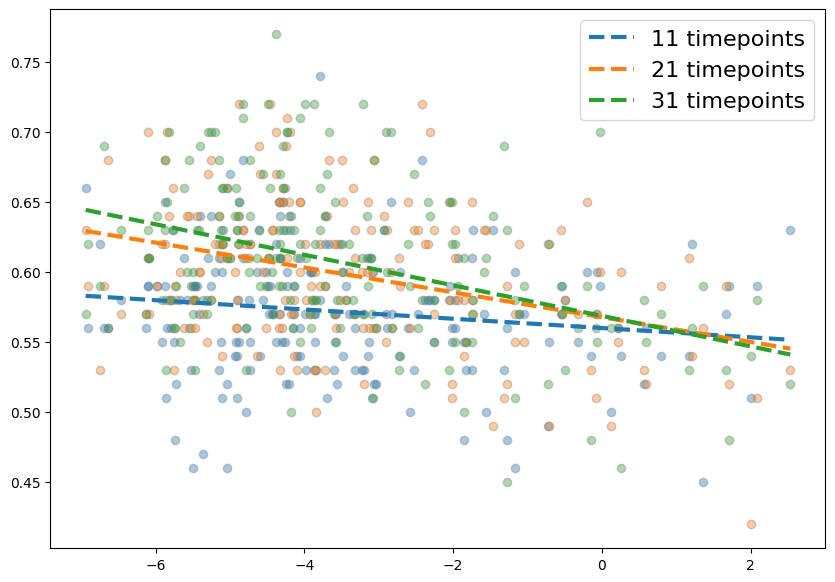

In [435]:
plt.figure(figsize=(10,7))

for j in range(len(metadict["n_tpoints"])):
    init_cond_msd = []
    csr = []
    for k in range(len(infer_out_list)):
        df_tmp = infer_out_list[k][(infer_out_list[k][["t_samp_dist_idx", "n_init_cond"]]==[j,1]).all(axis=1)]
        
        init_cond_idx = [int(re.findall("([0-9]+).0", i)[0]) for i in df_tmp.init_cond_idx]
        init_cond = metadict_list[k]["init_cond"][init_cond_idx]

        p = metadict_list[k]["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond-x_eq)**2).mean(axis=1))
        csr.append(df_tmp.CSR.values)

        plt.scatter(np.log(((init_cond-x_eq)**2).mean(axis=1)), df_tmp.CSR, 
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    init_cond_msd = np.concatenate(init_cond_msd)
    csr = np.concatenate(csr)

    reg = lm.LinearRegression()
    reg.fit(np.log(init_cond_msd).reshape((-1,1)), csr)
    plt.plot([np.log(init_cond_msd).min(), np.log(init_cond_msd).max()], 
             reg.predict([[np.log(init_cond_msd).min()], [np.log(init_cond_msd).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()

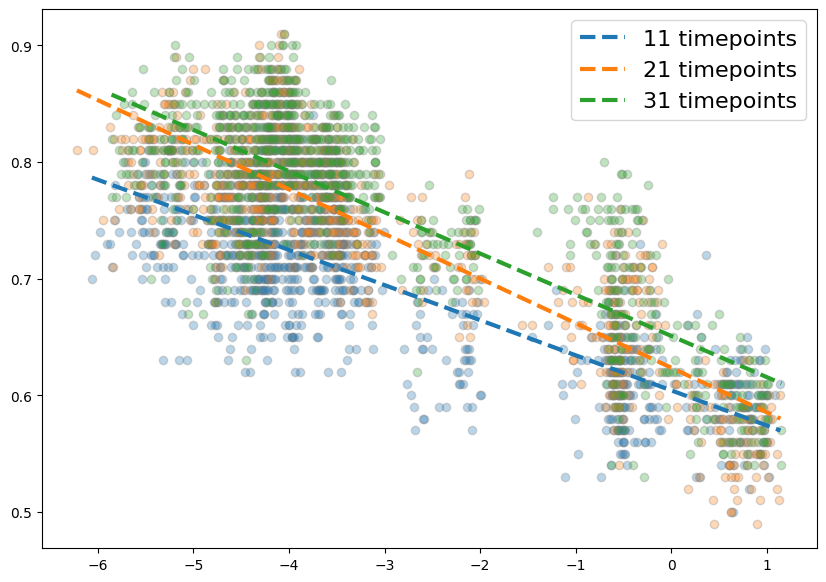

In [438]:
plt.figure(figsize=(10,7))

for j in range(len(metadict["n_tpoints"])):
    init_cond_var = []
    csr = []
    for k in range(len(infer_out_list)):
        df_tmp = infer_out_list[k][(infer_out_list[k][["t_samp_dist_idx", "n_init_cond"]]==[j,10]).all(axis=1)]
        
        init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)] for i in df_tmp.init_cond_idx.values]
        
        for l in range(len(init_cond_idx)):
            init_cond = metadict_list[k]["init_cond"][init_cond_idx[l]]

            init_cond_var.append(init_cond)
            csr.append(df_tmp.CSR.values[l])

    init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
    csr = np.array(csr)

    plt.scatter(np.log(init_cond_var), csr, 
                facecolors=f"C{j}", alpha=0.3, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(init_cond_var).reshape((-1,1)), csr)
    plt.plot([np.log(init_cond_var).min(), np.log(init_cond_var).max()], 
             reg.predict([[np.log(init_cond_var).min()], [np.log(init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()

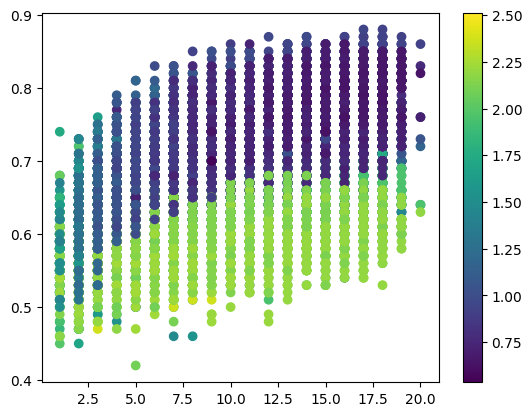

In [277]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==0]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD)
plt.colorbar()
plt.show()

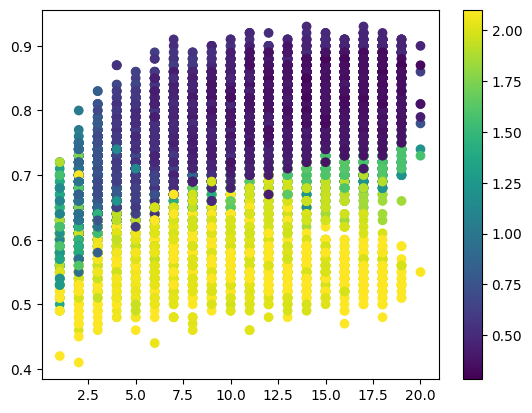

In [288]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==1]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD, vmax=np.percentile(df_tmp.MSPD, 95))
plt.colorbar()
plt.show()

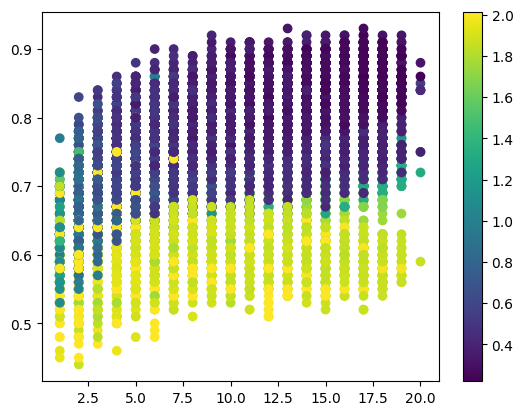

In [290]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==2]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD, vmax=np.percentile(df_tmp.MSPD, 95))
plt.colorbar()
plt.show()

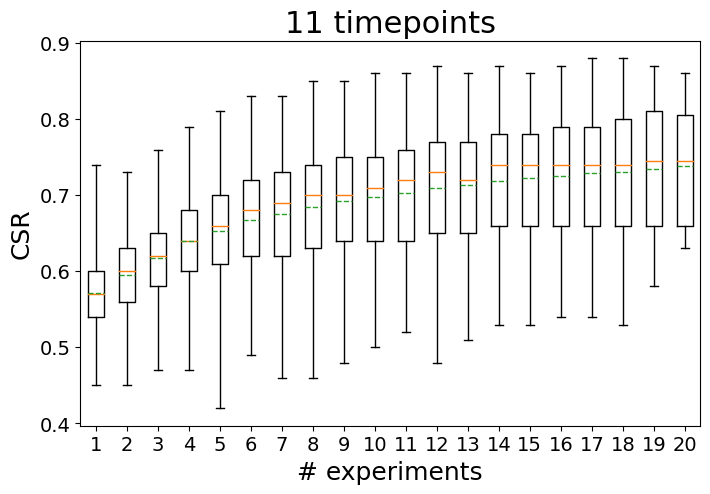

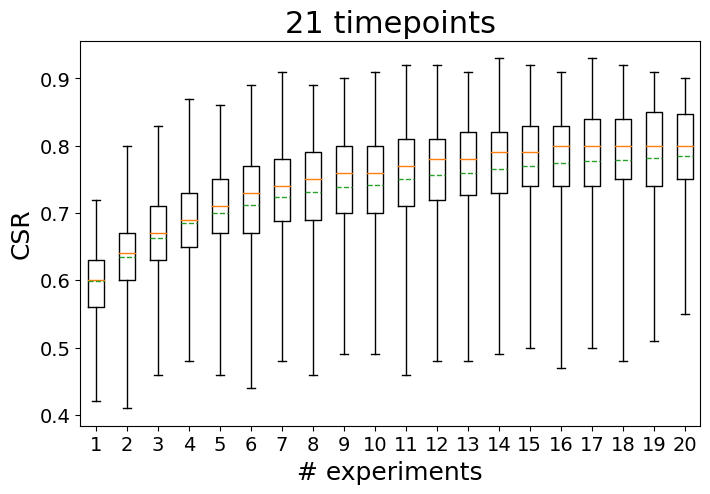

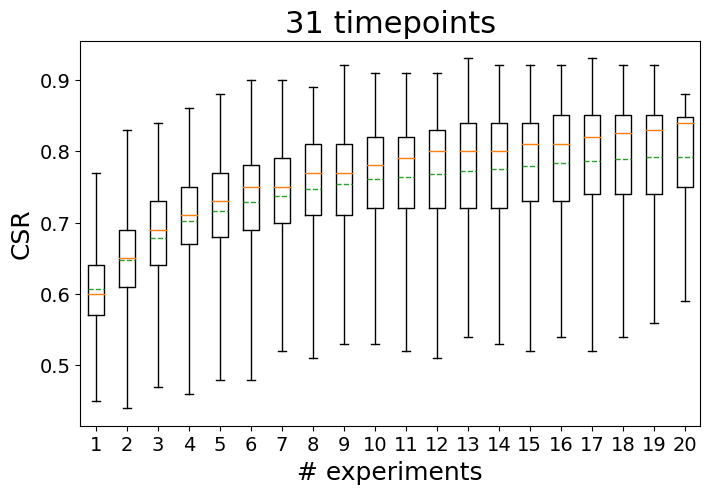

In [29]:
# CSR boxplot over # of experiments, by n_tpoints
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    CSR = [infer_out_all[(infer_out_all[["n_init_cond", "t_samp_dist_idx"]]==[i,t_samp]).all(axis=1)]["CSR"].values \
            for i in infer_out_all.n_init_cond.unique()]

    plt.figure(figsize=(8,5))
    plt.title(f"{metadict['n_tpoints'][int(t_samp)]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

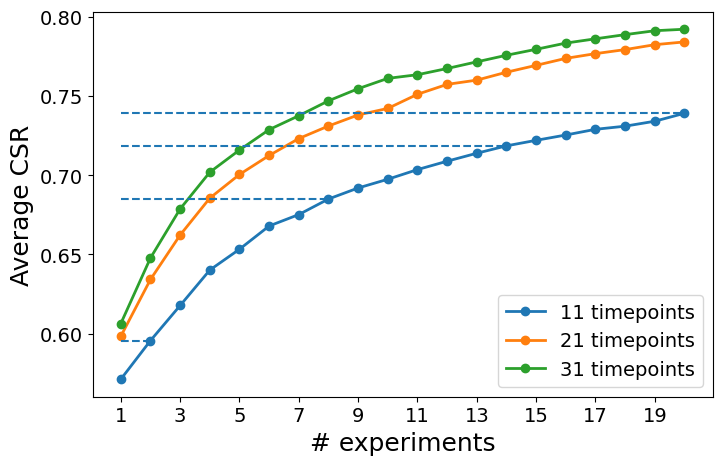

In [30]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()

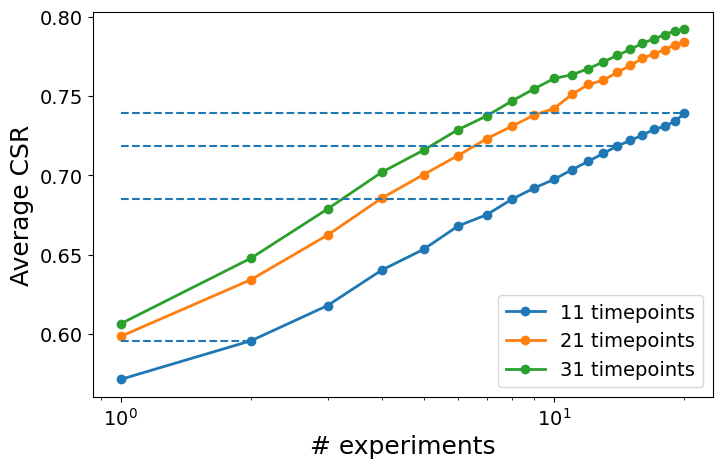

In [31]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
plt.show()

In [32]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1,j]/avgCSR[0,i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2,j]/avgCSR[0,i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2,j]/avgCSR[1,i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))

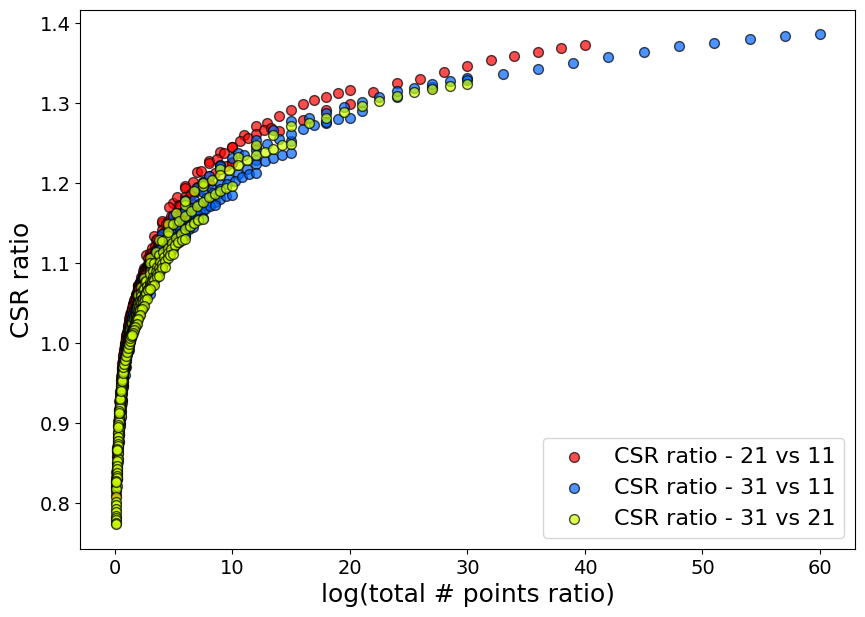

In [33]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

#12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9923067431194115
intercept = 1.00425, slope = 0.09685

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9885646721812009
intercept = 0.98361, slope = 0.09668

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9848629035147524
intercept = 0.98535, slope = 0.09186

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9810663744526827
intercept = 0.99166, slope = 0.09504


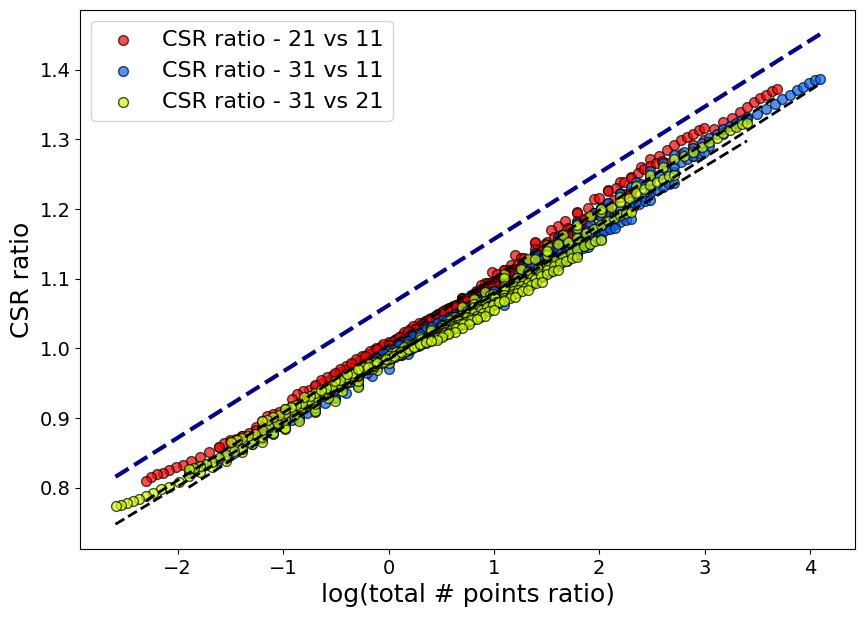

In [34]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9954545737678252
intercept = 0.00097, slope = 0.09062

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9911616268696529
intercept = -0.01673, slope = 0.08898

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9909577708545482
intercept = -0.01919, slope = 0.08981

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9848564919644566
intercept = -0.01171, slope = 0.08974


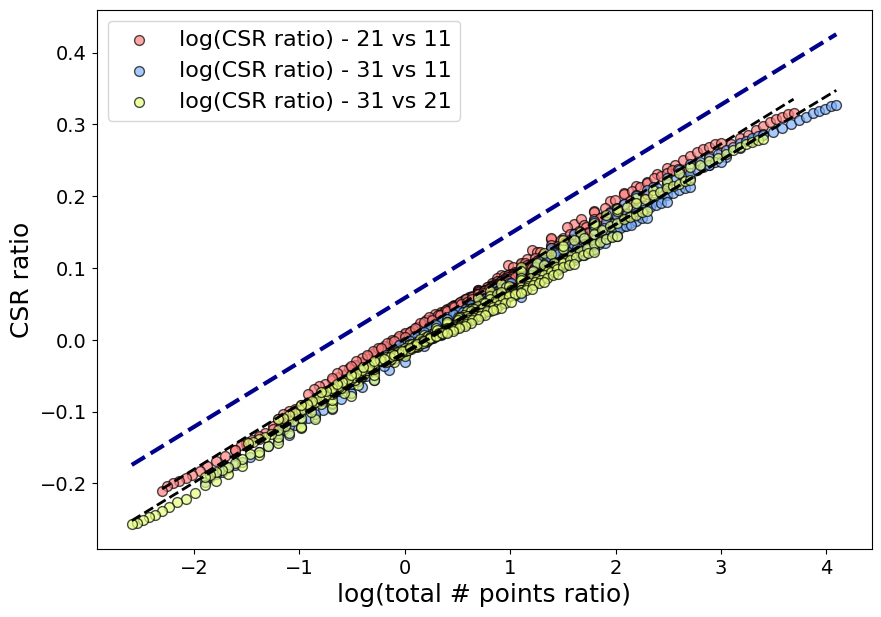

In [35]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

R2 score = 0.6096896038617818


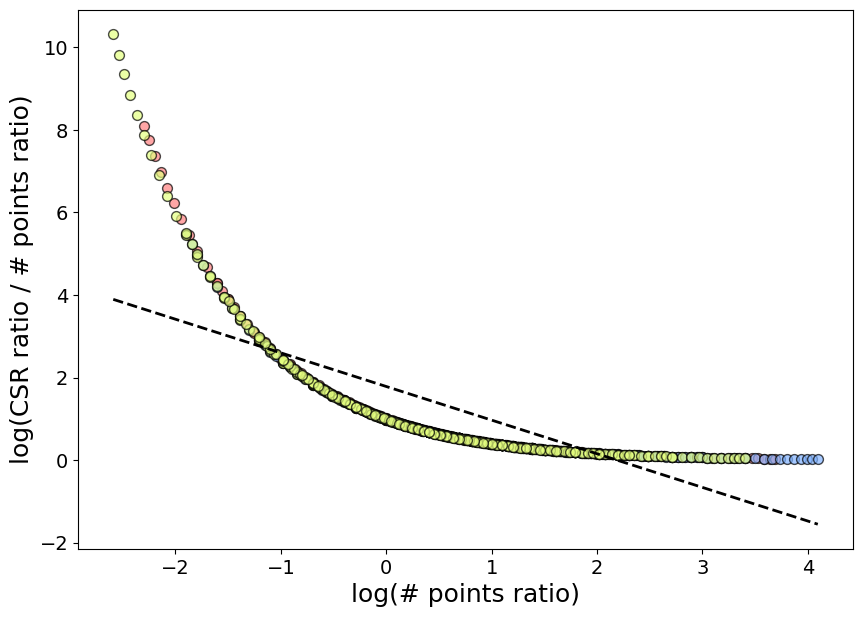

In [36]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01, 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02, 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12, 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

R2 score = 0.9998505701813806


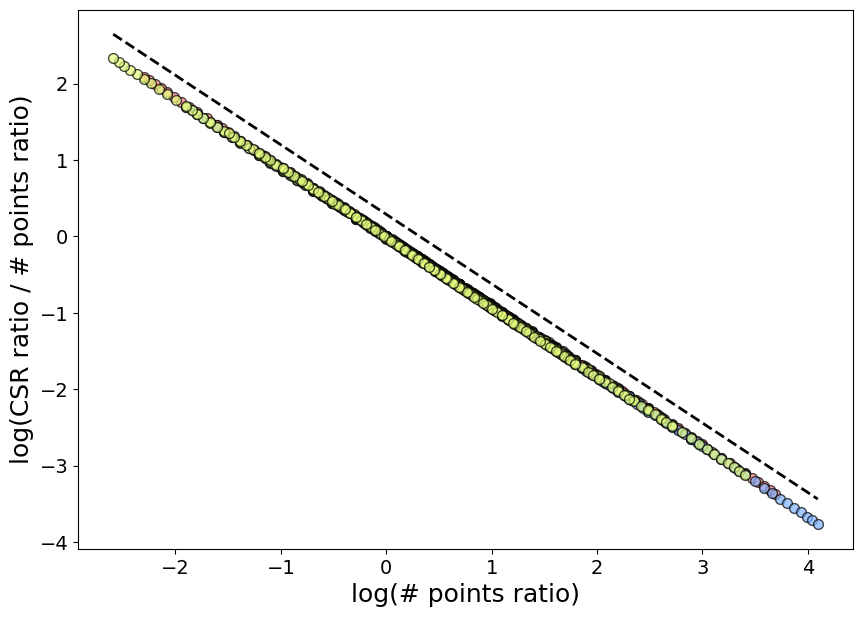

In [37]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01), 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02), 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12), 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

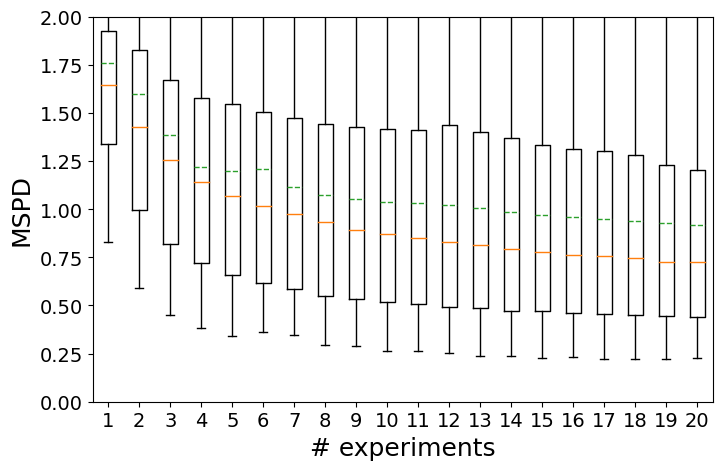

In [38]:
# MSPD boxplots over # of experiments

MSPD = [infer_out_all[infer_out_all.n_init_cond==i]["MSPD"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(MSPD, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("MSPD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale("log")
plt.ylim(0, 2)
plt.show()